In [0]:
# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Solución

### Carga de datos

Se organizan los datos de forma que queden todos en un solo DataFrame sin filas con fecha NA

In [0]:
### Carga de datos
import pandas as pd
### Trae todos los datos de github de 1995 a 2018
url1 = 'https://github.com/ANN-2019-2/evaluacion-dascardonaca/blob/master/datos/precios/Precio_Bolsa_Nacional_($kwh)_'
url2 = '.xlsx?raw=true'
dflist = []
skip = 3

for i in range(1995,2019):
    if i > 2015:
        url2 = '.xls?raw=true'
    url = url1 + str(i) + url2
    if i > 1999:
        skip = 2
    df = pd.read_excel(url,skiprows=skip,header=0)
    dflist.append(df)
## se unen todos los datos en un solo DataFrame
totaldf = dflist[0]
for df in dflist[1:]:
    totaldf= totaldf.append(df, sort=True)
## Se eliminan las filas con Fecha na
totaldf=totaldf.dropna(subset=['Fecha'])
df = totaldf

Como se trata de valores promedio del precio de la energía se calcula dicho valor, luego se cambia de dataframe para no cargar con todos los datos todo el tiempo

In [0]:
### Se calcula el valor promedio de la energía para cada fila(día)

import math
def calcularPromedio(row):
    suma=0
    total=24
    for i in range(24):
        if(math.isnan(row[str(i)])):
            total-=1
        else:
            suma+=row[str(i)]
    suma=suma/total
    return(suma)
df['promedio'] = df.apply(calcularPromedio, axis=1)

<function matplotlib.pyplot.show>

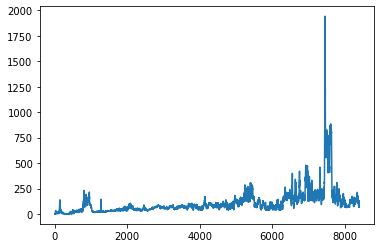

In [3]:
import numpy as np
import matplotlib.pyplot as plt
t = np.arange(0, len(df['promedio']), 1)
plt.plot(t,df['promedio'])
plt.show

In [4]:
df['promedio'].describe()

count    8400.000000
mean      107.256202
std       128.372835
min         0.499792
25%        46.001686
50%        74.653875
75%       132.123855
max      1942.692800
Name: promedio, dtype: float64

In [5]:
#### Se pasa a df1 solo los datos de Fecha y promedio
df1 = df[['Fecha','promedio']]
print(df1)

          Fecha   promedio
0    1995-07-20   1.409435
1    1995-07-21   4.924333
2    1995-07-22   1.269500
3    1995-07-23   0.953083
4    1995-07-24   4.305917
..          ...        ...
120  2018-05-01  71.666726
121  2018-05-02  76.374441
122  2018-05-03  71.148348
123  2018-05-04  64.710120
124  2018-05-05  73.972085

[8400 rows x 2 columns]


Ahora se cargan los datos del IPC, esto porque se nota una ligera tendencia creciente de los datos que puede ser debida a este factor, por lo que se quiere eliminar la variación de los precios debido a esto.

In [0]:
##### Se cargan los datos del IPC

url = 'https://github.com/ANN-2019-2/evaluacion-dascardonaca/blob/master/datos/1.2.5.IPC_Serie_variaciones.xlsx?raw=true'

skip = 12
ipc = pd.read_excel(url,skiprows=skip,header=0,nrows=320)

In [7]:
ipc

,Año(aaaa)-Mes(mm),Índice,Inflación anual,Inflación mensual,Inflación año corrido
0,202002,104.94,0.0372,0.0067,0.0109
1,202001,104.24,0.0362,0.0042,0.0042
2,201912,103.80,0.0380,0.0026,0.0380
3,201911,103.54,0.0384,0.0010,0.0354
4,201910,103.43,0.0386,0.0016,0.0343
...,...,...,...,...,...
315,199311,14.72,0.2237,0.0129,0.2123
316,199310,14.53,0.2169,0.0106,0.1968
317,199309,14.38,0.2143,0.0112,0.1842
318,199308,14.22,0.2107,0.0125,0.1710


Se preparan los datos para hacer la unión de los datos de una forma más fácil y luego se realiza dicha unión, posteriormente se estandarizan los precios diarios con el índice del IPC del último día en la base de datos.

In [8]:
### Se separan las fechas en año y mes para mayor facilidad
import math
def splitAno(row):
    return(str(row['Fecha'])[0:4])
df1['ano']=df1.apply(splitAno, axis=1)
def splitMes(row):
    return(str(row['Fecha'])[5:7])
df1['mes']=df1.apply(splitMes, axis=1)
def splitAnoIPC(row):
    return(str(row['Año(aaaa)-Mes(mm)'])[0:4])
ipc['ano']=ipc.apply(splitAnoIPC, axis=1)
def splitMesIPC(row):
    return(str(row['Año(aaaa)-Mes(mm)'])[4:6])
ipc['mes']=ipc.apply(splitMesIPC, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
## Se hace un merge del Dataframe de los datos de los precios con los datos del IPC
joineddf=df1.merge(ipc, on=['ano','mes'],how='left')

In [10]:
########### Se estandariza el precio promedio de forma que el ipc no lo afecta

def precioStandar(row,maxIndice):
    nuevo =row['promedio']*float(maxIndice)/float(row['Índice'])
    return(nuevo)
maxIndice=joineddf.max()['Índice']
print(maxIndice)
joineddf['promedioCorregido'] = joineddf.apply(precioStandar, axis=1, args=[maxIndice])


99.16


In [0]:
df=joineddf.drop(['Fecha','ano','mes','Año(aaaa)-Mes(mm)','Índice','Inflación anual','Inflación mensual','Inflación año corrido'],axis=1)

Ahora observamos la gráfica de los precios, se puede observar que se ha eliminado la mayor parte del comportamiento creciente de los precios.

<function matplotlib.pyplot.show>

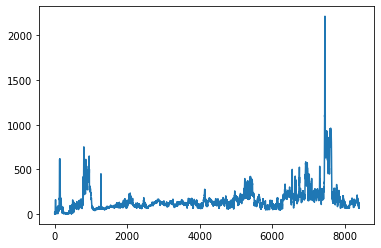

In [12]:
import numpy as np
import matplotlib.pyplot as plt
t = np.arange(0, len(df['promedioCorregido']), 1)
plt.plot(t,df['promedioCorregido'])
plt.show

In [13]:
df['promedioCorregido'].describe()

count    8400.000000
mean      158.281259
std       146.745782
min         2.367862
25%        88.970056
50%       124.213577
75%       175.429515
max      2214.732329
Name: promedioCorregido, dtype: float64

Se separan los datos en datos de Fit y datos de Test, para este caso los datos de test son solo los últimos 7 días que se tienen, esto porque es eso lo que se quiere predecir, una semana cada vez.

In [14]:
dffit=df[:-7]
dftest=df[-7:]
print(dftest)

       promedio  promedioCorregido
8393  70.595019          70.773452
8394  94.687618          94.926945
8395  71.666726          71.666726
8396  76.374441          76.374441
8397  71.148348          71.148348
8398  64.710120          64.710120
8399  73.972085          73.972085


Se crea la clase Adaline, este será nuestro tipo de modelo para la predicción.

En las ecuaciones donde debía ir el error, ya que los datos tienen algunos picos muy altos con respecto a los valores normales, en lugar de utilizar el error, se utilizará el vector unitario del error, tomando la dirección del error, pero minimizando los errores posteriores cuando haya picos en los datos.

In [0]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
class Adaline:
    def __init__(self,
                 momentum=0.5,
                 learning_rate=0.001, # tasa de aprendizaje
                 max_epochs=1,      # número máximo de iteraciones sobre el set de datos
                 random_state=None,   #
                 warm_start=False):   #
        
        self.momentum = momentum
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.warm_start = warm_start
        self.coef_ = None
        self.intercept_ = None
    def fit(self, X, y):

        if not isinstance(X, np.ndarray):
            X = np.array(X)
        if not isinstance(y, np.ndarray):
            d = np.array(y)
        else:
            d = y.copy()
        if self.random_state is not None:
            np.random.RandomState(self.random_state)

        if self.coef_ is None or self.warm_start is False:
            self.coef_ = np.random.uniform(-1, 1, X.shape[1])

        if self.intercept_ is None  or self.warm_start is False:
            self.intercept_ = np.random.uniform(-1, 1, 1)

        errors2 = []
        forecasts = []
        vintercepto = 0     
        v = 0               

        for i in range(X.shape[0]):
            u = np.dot(X[i,:], self.coef_) + self.intercept_
            e = (d[i] - u)[0]
            v = self.momentum * v + self.learning_rate * (e / abs(e)) * X[i,:]
            self.coef_ += v
            vintercepto = self.momentum * vintercepto + self.learning_rate * (e / abs(e)) 
            self.intercept_ += vintercepto
            errors2.append(e**2)
            forecasts.append(u)
        mse = (mean_squared_error(y, forecasts))
        mae = (mean_absolute_error(y, forecasts))
        return mse, mae

    def predict(self, X):
        if not isinstance(X, np.ndarray):
            X = np.array(X)
        u = np.dot(X, self.coef_) + self.intercept_
        return u

In [0]:
%matplotlib inline

Se define la funcion para aplicar transformaciones a los datos y se definen las transformaciones y sus transformaciones inversas.

Luego se procede a generar nuestros modelos para esto se itersa sobre las posibles transformaciones de los datos, la cantidad de rezagos (L), el momentum y la tasa de aprendizaje, se entrena el modelo y luego se estima con los valores de los datos de prueba para realizar el calculo del error, siempre los datos estimados se destransforman para obtener el precio estandarizado estimado y poder comparar dichos modelos.

In [26]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

d = (dffit['promedioCorregido'])
y = (dftest['promedioCorregido'])

def transformar(vector,Strans,trans):
    newVector=[]
    for element in vector:
        #print(trans(element))
        newVector.append(trans(element))
    #print(newVector)
    newVector=pd.DataFrame(newVector,columns=[Strans])
    return newVector


transformations = {}
transformations['-'] = lambda i: i
transformations['^2'] = lambda i : i**2
transformations['^3'] = lambda i: i**3
transformations['raiz2'] = lambda i: i ** (1. / 2)
transformations['raiz3'] = lambda i: np.cbrt(i)
transformations['ln']=lambda i: math.log(i)

itransformations = {}
itransformations['-'] = lambda i: i
itransformations['^2'] = lambda i : i ** (1. /2)
itransformations['^3'] = lambda i: np.cbrt(i)
itransformations['raiz2'] = lambda i: i ** 2
itransformations['raiz3'] = lambda i: i ** 3
itransformations['ln']=lambda i: math.exp(i)



lrs = np.arange(0.1, 1, 0.1).tolist()
mus =  np.arange(0.0, 1, 0.1).tolist()
adaline = {}
errors2 = {}
forecasts = {}


scaler = MinMaxScaler()

transformado = {}
mses = {}
maes = {}
predmaes = {}
predmses = {}
y_pred = {}
## for para las transformaciones
for trans in transformations:
    transformado[trans] = transformar(d,trans,transformations[trans])
    dd = scaler.fit_transform(transformado[trans])
    dd = pd.DataFrame(dd, columns=[trans])

    for L in range(7,15):

        X = []
        ## For para generar los conjuntos de datos para el adaline
        for t in range(L, len(dd)):
            X.append(dd[trans][t-L:t].copy())
        ## For para el learning rate (lr)
        for lr in lrs:
            ## For para el momentum (mu)
            for mu in mus:
                s = "%s %d %.2f %.2f" %(trans,L,lr,mu)
                adaline[s] = Adaline( learning_rate=lr,  # tasa de aprendizaje
                                momentum=mu,          # momentum
                                max_epochs=1,         # número máximo de iteraciones sobre el set de datos
                                #shuffle=False,       # mezcla patrones para aprendizaje online
                                random_state=1,       # corrida reproducible
                                warm_start=False)     # inicia con pesos aleatorios
                try:
                    mses[s], maes[s] = adaline[s].fit(X,  dd[L:])
                except:
                    mses[s] = math.inf
                    maes[s] = math.inf
                    #### metricas de error de entrenamiento
                
                for dia in range(len(dftest)):
                    if dia == 0:
                        pred=X[-1]
                        
                        pred=pred[1:].append(pd.DataFrame(adaline[s].predict(pred))[0])      
                    else:
                        pred=pred[1:].append(pd.DataFrame(adaline[s].predict(pred))[0]) 
                try:
                    ypred = pred[-7:]
                    ypred = scaler.inverse_transform(pd.DataFrame(ypred))
                    y_pred[s] = transformar(ypred,trans,itransformations[trans])    
                    mse = (mean_squared_error(y, y_pred[s]))
                    mae = (mean_absolute_error(y, y_pred[s]))
                    predmaes[s] = mae
                    predmses[s] = mse
                except:
                    ypred = pred[-7:]
                    ypred = scaler.inverse_transform(pd.DataFrame(ypred))
                    predmaes[s] = math.inf
                    predmses[s] = math.inf

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning:

###Tras obtener todos los resultados se buscan los mejores

Esto tanto para los errores de entrenamiento, como los de validación

En azul y verde, los resultados de los modelos con los mejores errores de validación

En rojo y amarillo, los resultados de los modelos con los mejores errores de entrenamiento

ln 7 0.10 0.10
ln 7 0.10 0.10
^3 11 0.10 0.50
^2 8 0.10 0.40


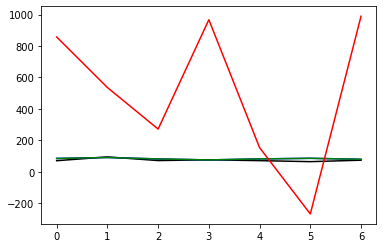

In [27]:
aa = plt.subplot()
b = list(range(len(y)))
aa.plot(b, y, color='black');

key_min = min(predmaes.keys(), key=(lambda k: predmaes[k]))
print(key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='blue');

key_min = min(predmses.keys(), key=(lambda k: predmses[k]))
print(key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='green');
key_min = min(maes.keys(), key=(lambda k: maes[k]))
print(key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='red');
key_min = min(mses.keys(), key=(lambda k: mses[k]))
print(key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='yellow');

plt.show()

Comparando, nos damos cuenta que los mejores adaptados son los de menor error de validación, que para este caso fue el mismo.

Observamos también cuál fue su error de entrenamiento

clave del modelo: (transformación, L, lr, mu)  ln 7 0.10 0.10
mae:  0.16338147116546806
mse:  0.03914644710726195


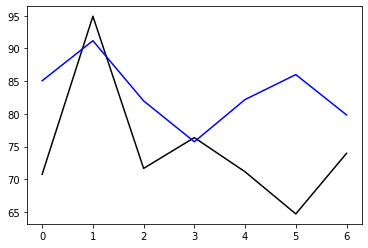

In [29]:
aa = plt.subplot()
b = list(range(len(y)))
aa.plot(b, y, color='black');

key_min = min(predmaes.keys(), key=(lambda k: predmaes[k]))
print('clave del modelo: (transformación, L, lr, mu) ', key_min)
print('mae: ',maes[key_min])
print('mse: ',mses[key_min])
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='blue');

plt.show()

Al observar los resultados anteriores, he decidido continuar intentando mejorar los resultados haciendo más precisos los valores de tasa de aprendizaje y momentum

In [0]:
import numpy as np

d = (dffit['promedioCorregido'])
y = (dftest['promedioCorregido'])


### lr alrededor de 0.10
lrs = np.arange(0.01, 0.2, 0.01).tolist()
### mu alrededor de 0.10
mus =  np.arange(0.00, 0.2, 0.01).tolist()
adaline = {}
errors2 = {}
forecasts = {}

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

transformado = {}
mses = {}
maes = {}
predmaes = {}
predmses = {}
y_pred = {}

tr='ln'


transformado[tr] = transformar(d,trans,transformations[tr])

## Se interpolan los datos a 0 , 1 para que no se generen errores.
dd = scaler.fit_transform(transformado[tr])
dd = pd.DataFrame(dd, columns=[tr])
#yy = pd.DataFrame(scaler.transform(ytransformado))

#L FIJO = 7
L=7

X = []
## For para generar los conjuntos de datos para el adaline
for t in range(L, len(dd)):
    X.append(dd[tr][t-L:t].copy())
## For para el learning rate (lr)
for lr in lrs:
    ## For para el momentum (mu)
    for mu in mus:
        s = "%s %d %.2f %.2f" %(tr,L,lr,mu)

        adaline[s] = Adaline( learning_rate=lr,  # tasa de aprendizaje
                        momentum=mu,          # momentum
                        max_epochs=1,         # número máximo de iteraciones sobre el set de datos
                        #shuffle=False,       # mezcla patrones para aprendizaje online
                        random_state=1,    # corrida reproducible
                        warm_start=False)     # inicia con pesos aleatorios
        try:
            mses[s], maes[s] = adaline[s].fit(X,  dd[L:])
        except:
            mses[s] = math.inf
            maes[s] = math.inf
            #### metricas de error de entrenamiento
        
        for dia in range(len(dftest)):
            if dia == 0:
                pred=X[-1]
                
                pred=pred[1:].append(pd.DataFrame(adaline[s].predict(pred))[0])      
            else:
                pred=pred[1:].append(pd.DataFrame(adaline[s].predict(pred))[0]) 
        try:
            ypred = pred[-7:]
            ypred = scaler.inverse_transform(pd.DataFrame(ypred))
            y_pred[s] = transformar(ypred,trans,itransformations[trans])    
            mse = (mean_squared_error(y, y_pred[s]))
            mae = (mean_absolute_error(y, y_pred[s]))
            predmaes[s] = mae
            predmses[s] = mse
        except:
            ypred = pred[-7:]
            ypred = scaler.inverse_transform(pd.DataFrame(ypred))
            predmaes[s] = math.inf
            predmses[s] = math.inf


De nuevo, esta vez para los resultados con los parámetros optimizados.

En azul y verde, los resultados de los modelos con los mejores errores de validación

En rojo y amarillo, los resultados de los modelos con los mejores errores de entrenamiento

blue  ln 7 0.07 0.03
green  ln 7 0.07 0.03
red  ln 7 0.01 0.09
yellow ln 7 0.01 0.09


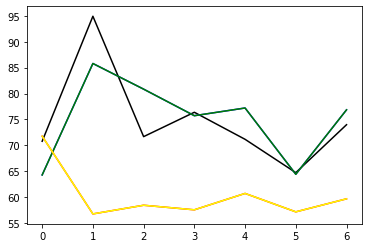

In [33]:
aa = plt.subplot()
b = list(range(len(y)))
aa.plot(b, y, color='black');

key_min = min(predmaes.keys(), key=(lambda k: predmaes[k]))
print('blue ',key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='blue');

key_min = min(predmses.keys(), key=(lambda k: predmses[k]))
print('green ',key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='green');

key_min = min(maes.keys(), key=(lambda k: maes[k]))
print('red ',key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='red');
key_min = min(mses.keys(), key=(lambda k: mses[k]))
print('yellow',key_min)
a = (y_pred[key_min])
b = list(range(len(a)))
aa.plot(b, a, color='yellow');

plt.show()

Observamos los errores de entrenamiento de los modelos recomendados y los comparamos

In [35]:
print('mse ln 7 0.07 0.03:',mses['ln 7 0.07 0.03'])
print('mse ln 7 0.01 0.09:',mses['ln 7 0.01 0.09'] )

mse ln 7 0.07 0.03: 0.020009644349287755
mse ln 7 0.01 0.09: 0.0014294433668313024


Al encontrar errores muy bajos también en el entrenamiento (teniendo en cuenta que estos errores son suceptibles de la transformación)

Podemos concluir, que con los datos dispoibles, con los pasos seguidos y teniendo en cuenta que se fijo el Random_state para las corridas, el modelo que mejor predice es el que tiene los siguientes parámetros:

Transformación elegida : Logaritmo natural

Número de rezagos: 7

Tasa de aprendizaje: 0.07

Momentum: 0.03

Sin embargo, hay que tener en cuenta que con otras metricas de error, transformaciones, o escalado de los datos, se podría llegar a un resultado distinto, también se podría variar el método para hallar los valores del learning rate, y momentum, por lo que este modelo podría ser mucho mejor.


